# Poppy JMLC - pince micro

In [1]:
%matplotlib inline
from pypot.creatures import PoppyTorso

In [2]:
import sys
OBJECT_DETECTION = "/home/poppy/train_tf1.3/models-r1.13.0/research/object_detection"
UTILS            = "/home/poppy/train_tf1.3/models-r1.13.0/research/object_detection/utils"
SLIM             = "/home/poppy/train_tf1.3/models-r1.13.0/research/object_detection/slim"

sys.path.append(OBJECT_DETECTION)
sys.path.append(UTILS)
sys.path.append(SLIM)

In [3]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

import ikpy
import time
import cv2
from IPython import display
from PIL import Image


def rescale_images(filePath, size=(800,480)):
    im = Image.open(filePath)
    im_resized = im.resize(size, Image.ANTIALIAS)
    im_resized.save(filePath)

### Preparing TF context

In [4]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from utils import ops as utils_ops
from utils import label_map_util
from utils import visualization_utils as vis_util
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1
# Patch the location of gfile
tf.gfile = tf.io.gfile

In [5]:
MODEL_NAME = os.path.join(OBJECT_DETECTION, 'inference_graph')
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = os.path.join(OBJECT_DETECTION, MODEL_NAME, 'frozen_inference_graph.pb')
NUM_CLASSES = 2

In [6]:
def load_model(model_name):
  model_dir = os.path.join(model_name,"saved_model")
  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']
  return model

In [7]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [8]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [9]:
def show_inference(model, image_path, detection_treshold=0.2):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=3,
      min_score_thresh= detection_treshold)

  im = Image.fromarray(image_np)
  display.display(im)
  im.save("/home/poppy/train_tf1.3/models-r1.13.0/research/object_detection/image.jpg")
  return output_dict, im

In [10]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join(OBJECT_DETECTION,'training', 'labelmap.pbtxt')
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [11]:
# What model to download.
detection_model = load_model(MODEL_NAME)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


# Creation of the robot

In [12]:
poppy = PoppyTorso()

In [5]:
poppy.compliant = True

In [13]:
poppy.compliant = False

In [14]:
def zero(wait=False):
    # Remet Poppy dans la position de base : 
    # tous les moteurs à zéro degré, non compliants, couple à 80% du max
    for m in poppy.motors :
        m.torque_limit=80
        m.goto_position(0,2.5,wait=wait)   
    poppy.head_y.goto_position(-10,0.5)


In [15]:
zero()

# API rest for moto detection

In [16]:
import pypot
from pypot.server.httpserver import HTTPRobotServer

server = HTTPRobotServer(poppy, host='127.0.0.1', port=8080)

In [17]:
from threading import Thread

Thread(target=lambda: server.run(quiet=True, server='wsgiref')).start()

# Tests

In [156]:
zero()

In [165]:
poppy.abs_z.goto_position(0,1)

In [163]:
poppy.l_arm_chain.end_effector

array([ 0.0377294 , -0.20165434,  0.06839934])

In [166]:
poppy.l_arm_chain.goto([ 0.0377294 , -0.20165434,  0.06839934], 5, accurate = True)

In [167]:
poppy.compliant = True

# Fonction qui met Poppy en position prise photo

In [18]:
! rm -f "/home/poppy/train_tf1.3/models-r1.13.0/research/object_detection/image.png"

In [19]:
def position_photo():
    delay=3
   # relever_main(delay)
    poppy.r_shoulder_y.goto_position(60,delay)
    poppy.r_elbow_y.goto_position(-40,delay)
    poppy.l_elbow_y.goto_position(-40,delay)
    poppy.l_shoulder_y.goto_position(60,delay)
    poppy.bust_y.goto_position(67,delay)
    poppy.head_y.goto_position(10,1)
    #poppy.abs_z.goto_position(40,1)
    poppy.head_z.goto_position(0,delay)
    

In [98]:
position_photo()

In [99]:
!python /home/poppy/train_tf1.3/models-r1.13.0/research/object_detection/photo.py

In [100]:
rescale_images("/home/poppy/train_tf1.3/models-r1.13.0/research/object_detection/image.jpg")

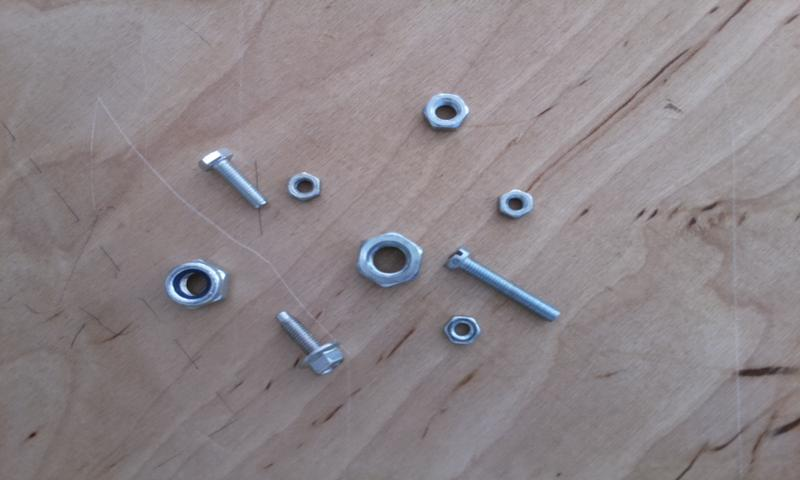

In [101]:
import matplotlib.pyplot as plt
IMAGE_SIZE = (12, 8)
image_path = "/home/poppy/train_tf1.3/models-r1.13.0/research/object_detection/image.jpg"
image = Image.open(image_path)
image_np = load_image_into_numpy_array(image)

plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)
display.display(image)

In [102]:
zero()

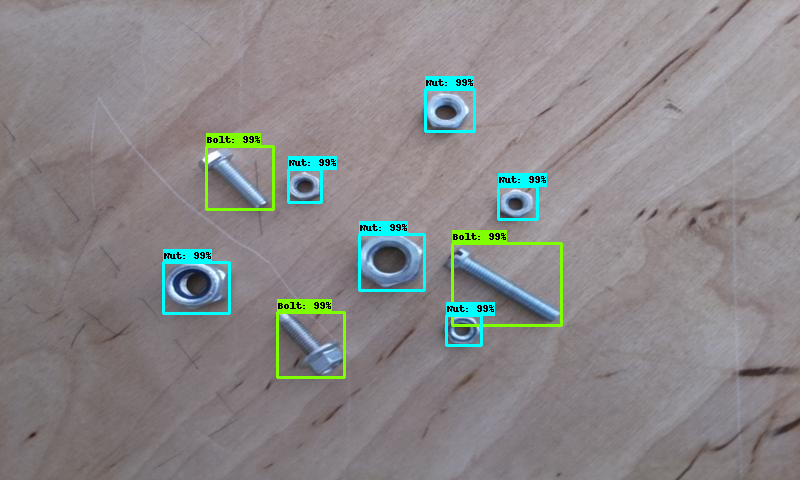

In [103]:
seuil=0.5
output_dict, im = show_inference(detection_model, image_path,  detection_treshold=seuil)

In [26]:
scores= output_dict["detection_scores"]

In [27]:
1-(scores>seuil)

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [28]:
last_rank = (1-(scores>=seuil)).argmax()
last_rank

3

In [29]:
scores[:last_rank]

array([0.9998889 , 0.9998883 , 0.99980235], dtype=float32)

In [30]:
types = output_dict["detection_classes"]  # 2-> nut (écrou) , 1 -> bolt (vis)
types[:last_rank]

array([2, 2, 2], dtype=int64)

In [31]:
height, width, _= image_np.shape
boxes = output_dict["detection_boxes"]
scale = np.ones_like(boxes)
boxes = boxes[:last_rank]

In [32]:
boxes = boxes*np.array([[width,height,width,height]])
print(boxes)

[[483.34093094 346.83926582 537.55803108 370.43789864]
 [258.40325356 212.91903019 312.76929379 235.2126646 ]
 [222.01457024 416.93395615 280.2164793  443.15531731]]


In [58]:
#dernier
coef_pixel_to_meter = 0.01/30
for score, type, boxe in zip(scores, types, boxes) :
    if type == 2:
        y_pix, x_pix = 0.5*(boxe[0]+boxe[2]), 0.5*(boxe[1]+boxe[3])
        y_m, x_m = y_pix*coef_pixel_to_meter, x_pix*coef_pixel_to_meter
        print(" y_pixels, x_pixels: {:.1f}, {:.1f}".format(y_pix, x_pix))
        print(" y_meters, x_meters: {:.3f}, {:.3f}\n".format(y_m, x_m ))

In [42]:
relever_main()
time.sleep(1)
zero()

NameError: name 'relever_main' is not defined

In [109]:
ouvre_pince()

In [110]:
ferme_pince_ecrou13()

In [106]:
baisser_main()

NameError: name 'baisser_main' is not defined

In [28]:
zero()

In [190]:
poppy.l_arm_chain.end_effector

array([ 0.10384584, -0.17292657,  0.06096544])

In [61]:
poppy.l_arm_chain.goto([0.1,-0.15,-0.03], 5, accurate = True)

In [27]:
poppy.compliant = False

In [40]:
#deuxieme
coef_pixel_to_meter = 0.01/30
for score, type, boxe in zip(scores, types, boxes) :
    if type == 2:
        y_pix, x_pix = 0.5*(boxe[0]+boxe[2]), 0.5*(boxe[1]+boxe[3])
        y_m, x_m = y_pix*coef_pixel_to_meter, x_pix*coef_pixel_to_meter
        print(" y_pixels, x_pixels: {:.1f}, {:.1f}".format(y_pix, x_pix))
        print(" y_meters, x_meters: {:.3f}, {:.3f}\n".format(y_m, x_m ))

In [33]:
#ancienne 
coef_pixel_to_meter = 0.01/30
for score, type, boxe in zip(scores, types, boxes) :
    if type == 2:
        y_pix, x_pix = 0.5*(boxe[0]+boxe[2]), 0.5*(boxe[1]+boxe[3])
        y_m, x_m = y_pix*coef_pixel_to_meter, x_pix*coef_pixel_to_meter
        print(" y_pixels, x_pixels: {:.1f}, {:.1f}".format(y_pix, x_pix))
        print(" y_meters, x_meters: {:.3f}, {:.3f}\n".format(y_m, x_m ))

# Faire une image 

# Pilotage pince

In [67]:
poppy._controllers[0].io

<DXL IO: closed=False, port="/dev/ttyACM1", baudrate=1000000, timeout=0.05>

In [68]:
poppy._controllers[0].io.get_used_ports()

['/dev/ttyACM1']

In [69]:
from pypot.dynamixel import Dxl320IO, get_available_ports
ports = get_available_ports()
if not ports:
    raise IOError('no serial port found!')
print('ports found:', ports)

ports found: ['/dev/ttyACM1', '/dev/ttyACM0', '/dev/ttyAMA0']


In [70]:
for i,port in enumerate(ports):
    if 'ttyACM' not in port:continue
    print(i,port)
    if port not in poppy._controllers[0].io.get_used_ports()[0]:
        print('port ',port ,' is free')
        num_port_free = i
        break
    
    

0 /dev/ttyACM1
1 /dev/ttyACM0
port  /dev/ttyACM0  is free


In [71]:
num_port_free

1

In [72]:
dxl_io_XL = Dxl320IO(ports[num_port_free])
print("created object:", dxl_io_XL)

created object: <DXL IO: closed=False, port="/dev/ttyACM0", baudrate=1000000, timeout=0.05>


In [73]:
dxl_io_XL.scan(range(40,50))

[45]

In [74]:
dxl_io_XL.set_moving_speed({45 : 50})

In [75]:
dxl_io_XL.set_goal_position({45 : 40}) 

In [16]:
dxl_io_XL.get_present_temperature([46])

(30.0,)

In [41]:
help(dxl_io_XL)

Help on Dxl320IO in module pypot.dynamixel.io.io_320 object:

class Dxl320IO(pypot.dynamixel.io.abstract_io.AbstractDxlIO)
 |  Dxl320IO(port, baudrate=1000000, timeout=0.05, use_sync_read=False, error_handler_cls=None, convert=True)
 |  
 |  Low-level class to handle the serial communication with the robotis motors.
 |  
 |  Method resolution order:
 |      Dxl320IO
 |      pypot.dynamixel.io.abstract_io.AbstractDxlIO
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  factory_reset(self, ids, except_ids=False, except_baudrate_and_ids=False)
 |      Reset all motors on the bus to their factory default settings.
 |  
 |  get_LED_color(self, ids, **kwargs)
 |      Gets LED color from the specified motors.
 |  
 |  get_alarm_shutdown(self, ids, **kwargs)
 |      Gets alarm shutdown from the specified motors.
 |  
 |  get_angle_limit(self, ids, **kwargs)
 |      Gets angle limit from the specified motors.
 |  
 |  get_control_mode(self, ids, **kwargs)
 |      Gets control mode 

In [17]:
dxl_io_XL.get_highest_temperature_limit([46])

(65.0,)

# Déclaration des fonctions

In [78]:
def ouvre_pince(delay=1, wait=True, id=45 , speed=50):
    dxl_io_XL.set_moving_speed({id : speed})
    dxl_io_XL.set_goal_position({id : -30}) 
    if wait: time.sleep(delay)

In [82]:
ouvre_pince()

In [80]:
def ferme_pince_ecrou13(delay=1, wait=True, id=45, angle=-95, speed=50):
    dxl_io_XL.set_moving_speed({id : speed})
    dxl_io_XL.set_goal_position({id : angle})
    if wait: time.sleep(delay)

In [83]:
ferme_pince_ecrou13()

In [36]:
def baisser_main(delay=1, wait=True, id=45 , speed=50):
    dxl_io_XL.set_moving_speed({id : speed})
    dxl_io_XL.set_goal_position({id : -20})
    if wait: time.sleep(delay)

In [162]:
baisser_main()

In [34]:
def relever_main(delay=1, wait=True, id=45, speed=50):
    dxl_io_XL.set_moving_speed({id : speed})
    dxl_io_XL.set_goal_position({id : 85})
    if wait: time.sleep(delay)

In [35]:
relever_main()

In [41]:
def position_init() :
    poppy.l_shoulder_y.goto_position(+80, 3, wait=False)
    poppy.l_shoulder_x.goto_position(0,3,wait = False)
    poppy.l_arm_z.goto_position(0,3,wait = False)
    poppy.l_elbow_y.goto_position(-45,3,wait = False)
    ouvre_pince()

In [323]:
position_init()

In [52]:
baisser_main()

In [39]:
workspeed = 3
def position_travail():
    poppy.l_shoulder_y.goto_position(+8, workspeed, wait = False)
    poppy.l_shoulder_x.goto_position(0, workspeed, wait = False)
    poppy.l_arm_z.goto_position(0, workspeed, wait = False)
    poppy.l_elbow_y.goto_position(-30, workspeed, wait = False)

In [40]:
relever_main()
time.sleep(1)
zero()
position_travail()

# La jour J

In [77]:
relever_main()
ouvre_pince()
zero()

In [35]:
poppy.compliant = False

In [65]:
poppy.head_z.goto_position(15,2)
poppy.head_y.goto_position(12,2)
poppy.l_arm_chain.goto([0.01,-0.25,0.14], 5, accurate = True)
time.sleep(2)
#baisser_main()
time.sleep(2)
#ferme_pince_ecrou13()
time.sleep(2)
#relever_main()
poppy.head_z.goto_position(-20,2)


In [66]:
poppy.head_z.goto_position(0,2)
poppy.abs_z.goto_position(-40,3)
poppy.l_elbow_y.goto_position(45,3)
time.sleep(3)
#ouvre_pince()

In [76]:
#relever_main()
#ouvre_pince()
zero()

In [ ]:
def au revoir():
    poppy.r_shoulder

In [75]:
poppy.l_arm_chain.goto([0.1,-0.15,0.0], 5, accurate = True)

In [67]:
baisser_main()

In [74]:
poppy.l_arm_chain.end_effector

array([ 0.00126315, -0.1991226 ,  0.12878649])

In [32]:
poppy.head_y.goto_position(10,2)
poppy.head_z.goto_position(15,2)
#ouvre_pince()
poppy.l_arm_chain.goto([ 0.1 , -0.25,  0.135], 2, accurate = True)
#time.sleep(5)
#baisser_main()
#time.sleep(2)
#ferme_pince_ecrou13()
time.sleep(2)
#relever_main()
time.sleep(2)
poppy.head_z.goto_position(45,2)
poppy.head_y.goto_position(10,2)
poppy.l_arm_chain.goto([ 0.2 , -0.15,  0.05], 2, accurate = True)
#time.sleep(5)
#ouvre_pince()
time.sleep(2)
#relever_main()
zero()
#time.sleep(2)
#position_init()

In [111]:
poppy.compliant = True

In [168]:
poppy.close()

In [66]:
dxl_io_XL.close()

In [ ]:
poppy